**Практическое задание №1 по курсу "Методы и технологии машинного обучения"**

*Арешин Станислав Олегович М8О-111М-21*

**Задание**

* Выбрать датасет для бинарной классификации

* Реализовать понижение размерности алгоритмом PCA и произвести классификацию алгоритмом SVC

* Построить графики зависимости метрик accuracy и f1 от размерности и выбрать оптимальную размерность

* Обучить алгоритм SVC для оптимальной размерности. Построить ROC кривую, вычислить AUC.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Предобработка

## Загрузка данных

Датасет https://www.kaggle.com/sveneschlbeck/nba-players-career-duration


Успех новичка НБА зависит от многих переменных - особенно от его игры в первом сезоне. Иногда можно использовать статистические данные о таких игроках, чтобы предсказать, проживут ли они 5 лет в НБА или нет.

Соответственно, целевая величина target_5yrs.

Сразу удалим признак name, так как это имя баскетболиста - уникальный идентификатор.

In [2]:
df = pd.read_csv('nba-players.csv').drop(['Unnamed: 0', 'name'], axis = 1)
df.head()

,gp,min,pts,fgm,fga,fg,3p_made,3pa,3p,ftm,fta,ft,oreb,dreb,reb,ast,stl,blk,tov,target_5yrs
0,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gp           1340 non-null   int64  
 1   min          1340 non-null   float64
 2   pts          1340 non-null   float64
 3   fgm          1340 non-null   float64
 4   fga          1340 non-null   float64
 5   fg           1340 non-null   float64
 6   3p_made      1340 non-null   float64
 7   3pa          1340 non-null   float64
 8   3p           1340 non-null   float64
 9   ftm          1340 non-null   float64
 10  fta          1340 non-null   float64
 11  ft           1340 non-null   float64
 12  oreb         1340 non-null   float64
 13  dreb         1340 non-null   float64
 14  reb          1340 non-null   float64
 15  ast          1340 non-null   float64
 16  stl          1340 non-null   float64
 17  blk          1340 non-null   float64
 18  tov          1340 non-null   float64
 19  target

Пропущенных значений нет, все признаки числовые. Итого имеем 19 признаков и целевую величину.

## Баланс целевой величины

Построим график баланса целевой величины

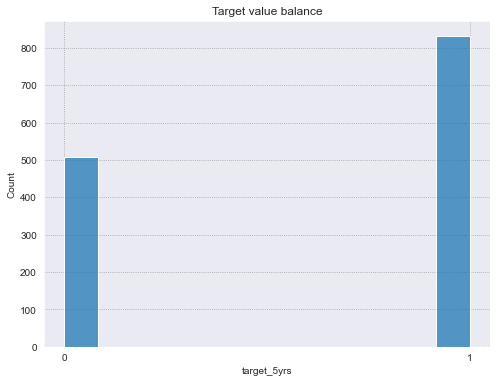

In [4]:
plt.figure(figsize=(8,6))
plt.title('Target value balance')
sns.histplot(data=df, x='target_5yrs')
plt.xticks([0,1])
plt.show()

Видно, что целевая величина не очень хорошо сбалансирована. Поэтому оптимальную размерность пространства лучше выбирать по метрике f1, так как accuracy плохо показывает качество алгоритма на несбалансированной выборке.

При обучении SVC стоит указать параметр class_weight = 'balanced' для корректного обучения алгоритма на несбалансированной выборке.

При выполнении train test split стоит указать параметр stratify по целевой величине, чтобы гарантировать примерно одинаковый баланс целевой величины в обучении и тесте. 

## Преобразование в np.array

In [5]:
y = df['target_5yrs'].to_numpy()
X = df.drop(['target_5yrs'], axis = 1).to_numpy()

# Выбор оптимальной размерности PCA

## Реализация перебора

Перебирая все размерности от 1 до X.shape[1] - 1: понизим размерность с помощью PCA, сделаем train_test_split с фиксированным random_state, обучим SVC и классифицируем. Полученные метрики accuracy и f1 сохраним в список для построения графиков.

Отдельно обучим алгоритм без понижения размерности, полученные метрики аналогично сохраним в список.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

accuracy = []
f1 = []

for num_components in range(1, X.shape[1]):
    pca = PCA(n_components = num_components)
    X_pca = pca.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.33,
                                                    random_state = 42,  stratify = y)
    model = SVC(class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,
                                                    random_state = 42,  stratify = y)
model = SVC(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy.append(accuracy_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))

print(accuracy)
print (f1)

[0.6636568848758465, 0.6636568848758465, 0.6523702031602708, 0.6659142212189616, 0.6568848758465011, 0.6613995485327314, 0.6568848758465011, 0.6568848758465011, 0.6591422121896162, 0.6591422121896162, 0.6591422121896162, 0.6591422121896162, 0.6591422121896162, 0.6591422121896162, 0.6591422121896162, 0.6591422121896162, 0.6591422121896162, 0.6591422121896162, 0.6681715575620768]
[0.6965376782077393, 0.7002012072434607, 0.692, 0.7086614173228346, 0.6984126984126984, 0.7035573122529644, 0.6984126984126984, 0.6984126984126984, 0.700990099009901, 0.700990099009901, 0.700990099009901, 0.700990099009901, 0.700990099009901, 0.700990099009901, 0.700990099009901, 0.700990099009901, 0.700990099009901, 0.700990099009901, 0.708910891089109]


## График accuracy в зависимости от размерности пространства

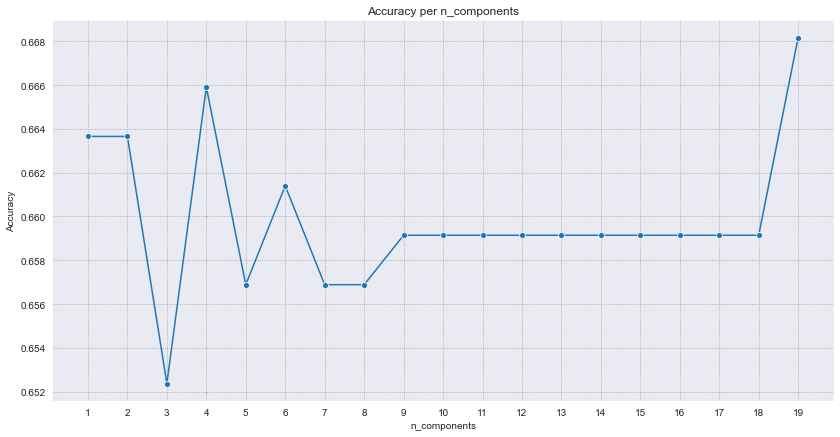

In [7]:
plt.figure(figsize=(14,7))
plt.title('Accuracy per n_components')
plt.xlabel('n_components')
plt.ylabel('Accuracy')
fig = sns.lineplot(x = range(1, X.shape[1] + 1), y= accuracy, marker="o")
plt.xticks(range(1, X.shape[1] + 1))
plt.show()

## График f1 score в зависимости от размерности пространства

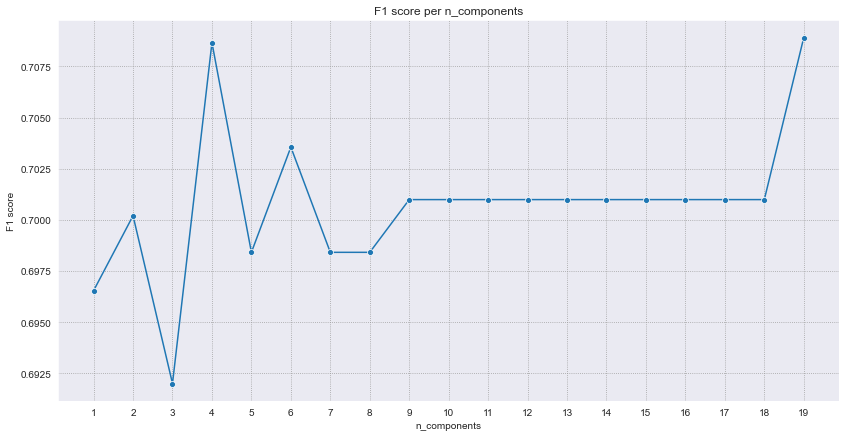

In [8]:
plt.figure(figsize=(14,7))
plt.title('F1 score per n_components')
plt.xlabel('n_components')
plt.ylabel('F1 score')
fig = sns.lineplot(x = range(1, X.shape[1] + 1), y= f1, marker="o")
plt.xticks(range(1, X.shape[1] + 1))
plt.show()

# Классификация SVC с оптимальной размерностью

## fit-predict

Лучший скор получен без понижения размерности, однако, для экономии вычислительных мощностей выберем лучший скор с понижением.

По графикам видно, что как для accuracy, так и для f1 score, лучший результат при понижении размерности: n_components = 4. 


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

pca = PCA(n_components = 4)
X_pca = pca.fit_transform(X)
    
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.33,
                                                    random_state = 42,  stratify = y)
model = SVC(class_weight='balanced', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.68      0.61       168
           1       0.77      0.65      0.71       275

    accuracy                           0.67       443
   macro avg       0.66      0.67      0.66       443
weighted avg       0.69      0.67      0.67       443



## Confusion matrix

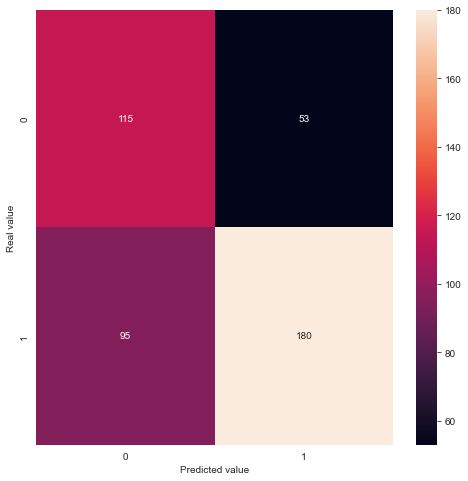

In [10]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.show()

## ROC кривая, метрика AUC

Построим ROC кривую для полученной модели и вычислим метрику AUC

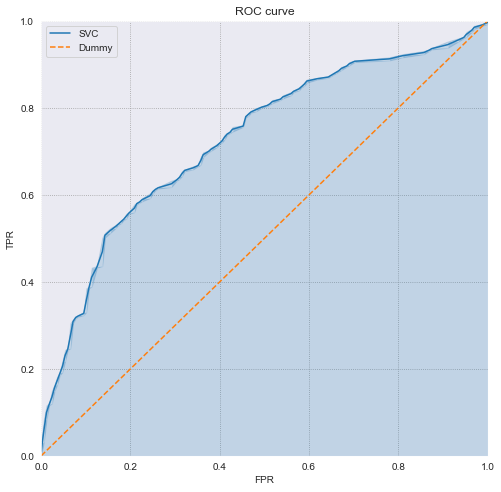

In [11]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])

plt.figure(figsize=(8,8))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0,1)
plt.ylim(0,1)

sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x=[0,1], y=[0,1], linestyle='--')
plt.legend(labels=['SVC', 'Dummy'])

plt.fill_between(fpr, tpr, alpha = 0.2)

plt.show()

In [12]:
print(f'AUC metric: {auc(fpr, tpr)}')

AUC metric: 0.7264069264069264
